## Rutina General 2019

A continuación se importan las librerías necesarias para el script.

In [1]:
from __future__ import print_function, division
import sunpy.timeseries
from sunpy.net import Fido, attrs as a
from sunpy.time import TimeRange
import sunpy.data.sample
import sunpy.map
from sunpy.util.metadata import MetaDict
from sunpy.time import parse_time
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import datetime
import math
from glob import glob
import cv2 as cv
import astropy.units as u
from astropy.time import Time
from astropy.table import Table
from astropy.io import fits
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import peak_local_max

El siguiente paso corresponde a mostrar las instrucciones del script y la solicitud de un rango de tiempo para buscar en la base de datos el TimeSeries del XRS (Sensor de Rayos X).

In [3]:
#Se imprime en la terminal la información del script
print("El presente script busca y descarga los TimeSeries de las curvas XRS,\na partir de un rango de tiempo que ingresa el usuario.")
print("Seguidamente se detectan los picos en las curvas y se extraen las fechas de dichos picos.")
print("Se define un delta de tiempo y se descargan las imágenes FITS. Finalmente se estudian las\nintensidades de las imágenes FITS en una región de interés (ROI).")
print("-------------------------------------------------------------------------------------------")
print("Ingrese las fechas en cualquiera de los siguientes formatos:\n- 2007-May-04 21:08:12\n- 2007-05-04T21:08:12\n- 2007/05/04T21:08:12")
print("- 20070504T210812\n- 20070504_210812\n")
initialTime = input("Ingrese fecha inicial: ")
finalTime = input("Ingrese fecha final: ")

#Se crea el timerange con los datos ingresados por el usuario, luego se imprime
time_range = TimeRange(initialTime, finalTime)
print("\nEl intervalo de tiempo ingresado es:\n", time_range)

El presente script busca y descarga los TimeSeries de las curvas XRS,
a partir de un rango de tiempo que ingresa el usuario.
Seguidamente se detectan los picos en las curvas y se extraen las fechas de dichos picos.
Se define un delta de tiempo y se descargan las imágenes FITS. Finalmente se estudian las
intensidades de las imágenes FITS en una región de interés (ROI).
-------------------------------------------------------------------------------------------
Ingrese las fechas en cualquiera de los siguientes formatos:
- 2007-May-04 21:08:12
- 2007-05-04T21:08:12
- 2007/05/04T21:08:12
- 20070504T210812
- 20070504_210812

Ingrese fecha inicial: 2011-06-07 05:30
Ingrese fecha final: 2011-06-07 06:00

El intervalo de tiempo ingresado es:
    Start: 2011-06-07 05:30:00
    End:   2011-06-07 06:00:00
    Center:2011-06-07 05:45:00
    Duration:0.020833333333333332 days or
           0.5 hours or
           30.0 minutes or
           1800.0 seconds



Lo anterior define un rango de tiempo proporsionado por el usuario. Se utiliza el objeto TimeSeries de la
librería Sunpy de Python. Cuando se imprime este objeto se observa la fecha inicial, la fecha final, el centro del intervalo y la duración en diferentes unidades.

Utilizando el TimeRange anterior, se busca y se descarga la curva del XRS. Para realizar la búsqueda se utiliza Fido.search() y se muestran los resultados de la búsqueda.

In [4]:
resultSearchXRS = Fido.search(a.Time(time_range.start, time_range.end), a.Instrument('XRS'))
resultSearchXRS

Start Time,End Time,Source,Instrument,Wavelength
str19,str19,str4,str4,str3
2011-06-07 00:00:00,2011-06-07 23:59:59,nasa,goes,nan


Se procede a descarga los datos de la curva. Se descargan los datos utilizando Fido.fetch() y se guardan en el path especificado.

In [5]:
filesXRS = Fido.fetch(resultSearchXRS, path='DatosJupyterSun/CurvasXRS')

[                                        ========================================


Ahora se crea un objeto TimeSeries, el cual contiene los datos descargados anteriormente, y se plotea.

/home/gabriel/anaconda3/envs/solar/lib/python3.7/site-packages/sunpy/timeseries/sources/goes.py:111: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


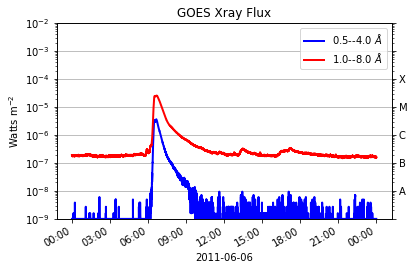

In [6]:
goesXRS_TS = sunpy.timeseries.TimeSeries(filesXRS, source= 'XRS')
goesXRS_TS.peek()

Se obtienen dos curvas, de las cuales se tomará la roja, que corresponde a los datos "xrsb". A esa curva se le deben encontrar los picos máximos. Para esto se utiliza la función findpeaks(series,Delta), la cual recibe los datos de una serie y un valor que corresponde a la sensibilidad.

In [7]:
def findpeaks(series, DELTA):
    # Valores iniciales
    mn, mx = np.Inf, -np.Inf
    minpeaks = []
    maxpeaks = []
    lookformax = True
    start = True
    # Se itera sobre cada uno de los elementos en la serie
    for time_pos, value in series.iteritems():
        if value > mx:
            mx = value
            mxpos = time_pos
        if value < mn:
            mn = value
            mnpos = time_pos
        if lookformax:
            if value < mx-DELTA:
                # un maximo local
                maxpeaks.append((mxpos, mx))
                mn = value
                mnpos = time_pos
                lookformax = False
            elif start:
                # un minimo local al principio
                minpeaks.append((mnpos, mn))
                mx = value
                mxpos = time_pos
                start = False
        else:
            if value > mn+DELTA:
                # minimo local
                minpeaks.append((mnpos, mn))
                mx = value
                mxpos = time_pos
                lookformax = True
    
    # Se revisa al principio y al final
    if value > mn+DELTA:
        maxpeaks.append((mxpos, mx))
    elif value < mx-DELTA:
        minpeaks.append((mnpos, mn))
    return minpeaks, maxpeaks

A continuación, se extraen los datos de la curva roja para pasarlos a la función findpeaks. El resultado se 
guarda en una arreglo, se imprime como un objeto DataFrame y se plotean los puntos encontrados sobre la figura.

Los picos máximos son:
                           0             1
0 2011-06-07 06:30:57.441999  2.456800e-05
1 2011-06-07 06:32:52.128999  2.448400e-05
2 2011-06-07 06:33:51.518999  2.450500e-05
3 2011-06-07 06:39:11.001999  2.546000e-05
4 2011-06-07 06:41:24.118999  2.555400e-05
5 2011-06-07 13:28:05.584999  3.224900e-07
6 2011-06-07 17:12:10.468999  3.434800e-07


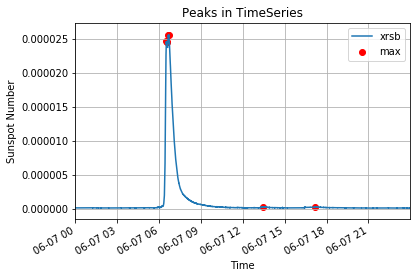

In [8]:
#Se extrae la serie xrsb
xrs_Series = goesXRS_TS.data['xrsb']

#Se extraen los picos mínimos y máximos de la serie
min_picos, max_picos = findpeaks(xrs_Series, DELTA=0.0000001)

#Se imprimen los picos máximos encontrados 
print ('Los picos máximos son:')
print (pd.DataFrame(max_picos))


#Se plotea la curva con los picos máximos 
plt.figure()
plt.ylabel('Sunspot Number')
plt.xlabel('Time')
plt.title('Peaks in TimeSeries')
xrs_Series.plot()
plt.scatter(*zip(*max_picos), color='red', label='max') # Punto de color rojo en máximos
plt.legend()
plt.grid(True)
plt.show()

Se necesita descartar los picos que sea menores a $10^{-6}$, se imprimen nuevamente como un DataFrame y vuelven a plotear los puntos sobre la curva.

Los picos máximos por encima de 1x10^(-6) son: 

                           0         1
0 2011-06-07 06:30:57.441999  0.000025
1 2011-06-07 06:32:52.128999  0.000024
2 2011-06-07 06:33:51.518999  0.000025
3 2011-06-07 06:39:11.001999  0.000025
4 2011-06-07 06:41:24.118999  0.000026


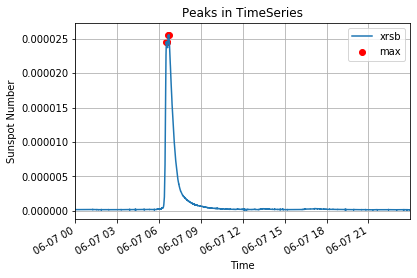

In [9]:
#Variable donde se guardarán los picos mayores a 1x10^(-6)
maxPicosArriba10e_m06 = []

#Se recorre y se revisa todos los máximos
for i in range(0, len(max_picos)-1):
    if max_picos[i][1] > 1.0e-06:
        maxPicosArriba10e_m06.append(max_picos[i])
    
#Se imprimen picos por encima del limite establecido
print ('Los picos máximos por encima de 1x10^(-6) son: \n')
print (pd.DataFrame(maxPicosArriba10e_m06))

#Se plotea la curva con los picos máximos 
plt.figure()
plt.ylabel('Sunspot Number')
plt.xlabel('Time')
plt.title('Peaks in TimeSeries')
xrs_Series.plot()
plt.scatter(*zip(*maxPicosArriba10e_m06), color='red', label='max')
plt.legend()
plt.grid(True)
plt.show()

Cuando los picos son identificados, se guardan en una archivo .csv mediante la utilización de pandas.

In [10]:
#Se define DataFrame de pandas para guardar información en archivo .csv
dataFrameMaxPicos = pd.DataFrame(maxPicosArriba10e_m06)
dataFrameMaxPicos.to_csv('DatosJupyterSun/maxPicos.csv', sep='\t', index=False)

A continuación se define la función returnDataRange(centralDate, delta_min), la cual toma las fechas de los picos máximos detectados en las curvas, y crea un rango de tiempo con un delta_min = 30 min antes y después.


In [11]:
#Define un TimeRange de una hora, a partir de la hora central extraída
#en la curva XRS. Con el TimeRange se busca en la base de datos JSOC
#los archivos FITS
def returnDataRange(centralDate, delta_min):
    date_rangeUp = TimeRange(centralDate, delta_min * u.min).previous()
    date_rangeFinal = TimeRange(date_rangeUp.start, date_rangeUp.next().end)
    return date_rangeFinal

#Se define el TimeRange, a partir de un pico máximo
maxPicoTR = returnDataRange(maxPicosArriba10e_m06[4][0], 30)
print (maxPicoTR)

    Start: 2011-06-07 06:11:24
    End:   2011-06-07 07:11:24
    Center:2011-06-07 06:41:24
    Duration:0.041666666666666664 days or
           1.0 hours or
           60.0 minutes or
           3600.0 seconds



Se necesita obtener un rango de tiempo de los picos, para lo cual se utiliza la función returnDataRange(centralDate, delta_min),
que toma la fecha de los picos con un delta de tiempo de 30 minutos antes y después.

In [12]:
#Se busca en el rango de tiempo definido anteriormente, los datos corresponden
#a la serie aia.lev1 con una cadencia de 12 segundos, una longitud de onda de
#193 Ångström
resultsAIA = Fido.search(a.jsoc.Time(maxPicoTR.start, maxPicoTR.end), a.jsoc.Series('aia.lev1_euv_12s'), a.jsoc.Wavelength(193*u.AA), a.vso.Sample(2*u.minute),  a.jsoc.Notify('yasser.wagon@ucr.ac.cr'))
resultsAIA

T_REC,TELESCOP,INSTRUME,WAVELNTH,CAR_ROT
str20,str7,str5,int64,int64
2011-06-07T06:11:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:13:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:15:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:17:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:19:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:21:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:23:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:25:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:27:26Z,SDO/AIA,AIA_2,193,2111


Se procede a descargar los archivos FITS

In [13]:
#Se descargan los archivos FITS
downloaded_files = Fido.fetch(resultsAIA, path='DatosJupyterSun/JSOC_AIA_FITS/{file}.fits')

Export request pending. [id="JSOC_20190529_459", status=2]
Waiting for 0 seconds...
Skipping download of file aia.lev1_euv_12s.2011-06-07T061133Z.193.image_lev1.fits as it has already been downloaded. If you want to redownload the data, please set overwrite to True
Skipping download of file aia.lev1_euv_12s.2011-06-07T061133Z.193.spikes.fits as it has already been downloaded. If you want to redownload the data, please set overwrite to True
Skipping download of file aia.lev1_euv_12s.2011-06-07T061333Z.193.image_lev1.fits as it has already been downloaded. If you want to redownload the data, please set overwrite to True
Skipping download of file aia.lev1_euv_12s.2011-06-07T061333Z.193.spikes.fits as it has already been downloaded. If you want to redownload the data, please set overwrite to True
Skipping download of file aia.lev1_euv_12s.2011-06-07T061533Z.193.image_lev1.fits as it has already been downloaded. If you want to redownload the data, please set overwrite to True
Skipping downl

[                                        ]========================================


Ahora, se debe abrir el archivo FITS para convertirlo en un objeto map de Sunpy.

/home/gabriel/anaconda3/envs/solar/lib/python3.7/site-packages/sunpy/map/mapbase.py:759: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [1/lam * np.sin(p), np.cos(p)]])
/home/gabriel/anaconda3/envs/solar/lib/python3.7/site-packages/sunpy/map/mapbase.py:759: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [1/lam * np.sin(p), np.cos(p)]])


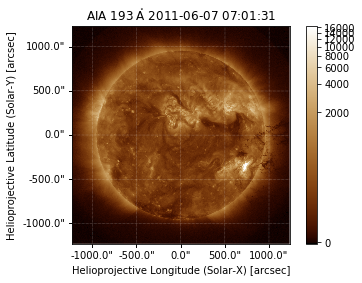

In [14]:
#Se abre archivo FITS y se convierte a un objeto map de sunpy
fits_image_filename = 'DatosJupyterSun/JSOC_AIA_FITS/aia.lev1_euv_12s.2011-06-07T070133Z.193.image_lev1.fits'

aiamap = sunpy.map.Map(fits_image_filename)
aiamap1 = sunpy.map.Map(fits_image_filename)

plt.figure()
aiamap.plot()
plt.colorbar()

Se delimita la zona de interés con un cuadro de lado igual a (2)(0.75*R_SUN) y centrado en el disco solar. Para ello se ingresa al metadata del map y se extraen las coordenadas en pixeles del sol, además del radio, y se guardan en variables.

In [15]:
crpix1 = int(aiamap.meta['CRPIX1'])
crpix2 = int(aiamap.meta['CRPIX2'])
rSun = int(aiamap.meta['R_SUN'])
sunCenter = np.array([crpix1, crpix2])

print('El centro del disco solar está en el punto: ', sunCenter, 'pixel')
print ('El radio del sol en pixeles es: ', rSun, 'pixeles')

El centro del disco solar está en el punto:  [2044 2048] pixel
El radio del sol en pixeles es:  1574 pixeles


Se define la función, drawROI(sunImageData, sunCenter, pixRadius, proportion), que se encargará de dibujar un cuadro que delimitará la ROI.

In [16]:
def drawROI(sunImageData, sunCenter, pixRadius, proportion):
    propRadius = int(proportion * pixRadius)
#    cv.rectangle(sunImageData, (sunCenter[0] - propRadius, sunCenter[1] - propRadius), (sunCenter[0] + propRadius, sunCenter[1] + propRadius), 0, 30)
    cv.circle(sunImageData, (sunCenter[0], sunCenter[1]), propRadius, 0, 30, cv.LINE_AA)
    return sunImageData

Se dibuja el ROI sobre el map del archivo FITS abierto y se gráfica.

/home/gabriel/anaconda3/envs/solar/lib/python3.7/site-packages/sunpy/map/mapbase.py:759: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [1/lam * np.sin(p), np.cos(p)]])
/home/gabriel/anaconda3/envs/solar/lib/python3.7/site-packages/sunpy/map/mapbase.py:759: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [1/lam * np.sin(p), np.cos(p)]])


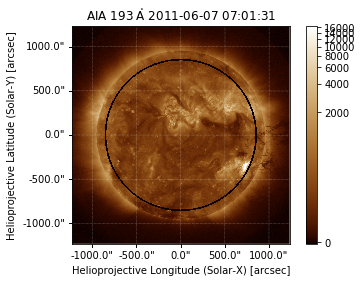

In [17]:
drawROI(aiamap.data, sunCenter, rSun, 0.90)
plt.figure()
aiamap.plot()
plt.colorbar()

Deben ubucarse los picos de alta intensidad en el mapa; para esto se utiliza la función peak_local_max(). Se debe definir los pixeles de alta intensidad, los que sean al menos un 80% del pixel más intenso.

In [18]:
coorPicos = peak_local_max(aiamap.data, min_distance=200, threshold_rel=0.2)
print('Los puntos de alta intensidad en el map son: \n')
print (pd.DataFrame(coorPicos))

Los puntos de alta intensidad en el map son: 

      0     1
0  2524  3361
1  2517  2949
2  2365   493
3  2330  1846
4  2295  2360
5  1482  3256


Ahora se deben marcar los picos de alta intensidad en el mapa.

/home/gabriel/anaconda3/envs/solar/lib/python3.7/site-packages/sunpy/map/mapbase.py:759: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [1/lam * np.sin(p), np.cos(p)]])
/home/gabriel/anaconda3/envs/solar/lib/python3.7/site-packages/sunpy/map/mapbase.py:759: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [1/lam * np.sin(p), np.cos(p)]])
/home/gabriel/anaconda3/envs/solar/lib/python3.7/site-packages/sunpy/map/mapbase.py:759: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-

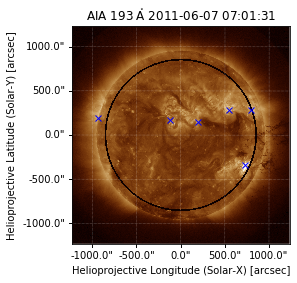

In [19]:
hpc_max = aiamap.pixel_to_world(coorPicos[:, 1]*u.pixel, coorPicos[:, 0]*u.pixel)
fig = plt.figure()
ax = plt.subplot(projection=aiamap)
aiamap.plot()
ax.plot_coord(hpc_max, 'bx')
plt.show()

Deben descartarse los picos que estén fuera del ROI, para eso es la función picosROI().

In [20]:
def picosROI(coordenadasPicos, sunCenter, pixRadius, prop):
    propRadius = int(prop * pixRadius)
    picosEnROI = []
    picosEnROICircular = []
    for l in range(0, len(coordenadasPicos)-1):
        r_peak = math.sqrt(((coordenadasPicos[l][0]-sunCenter[0])**2) + ((coordenadasPicos[l][1]-sunCenter[1])**2))
        if (r_peak < propRadius):
            picosEnROICircular.append(coordenadasPicos[l])
        
        
    for s in range(0, len(coordenadasPicos)-1):
        if (coordenadasPicos[s][0] > sunCenter[0] - propRadius and coordenadasPicos[s][0] < sunCenter[0] + propRadius):
            if(coordenadasPicos[s][1] > sunCenter[1] - propRadius and coordenadasPicos[s][1] < sunCenter[1] + propRadius):
                picosEnROI.append(coordenadasPicos[s])
                
    return np.array(picosEnROI), np.array(picosEnROICircular)

Ahora se ubican los pricos de alta intensidad y marcan en el mapa.

/home/gabriel/anaconda3/envs/solar/lib/python3.7/site-packages/sunpy/map/mapbase.py:759: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [1/lam * np.sin(p), np.cos(p)]])
/home/gabriel/anaconda3/envs/solar/lib/python3.7/site-packages/sunpy/map/mapbase.py:759: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [1/lam * np.sin(p), np.cos(p)]])
/home/gabriel/anaconda3/envs/solar/lib/python3.7/site-packages/sunpy/map/mapbase.py:759: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-

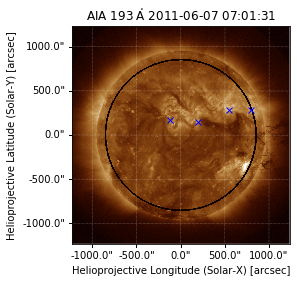

In [21]:
#Se ubican los picos de alta intensidad dentro del ROI 
picosen_roi, picosCircu = picosROI(coorPicos, sunCenter, rSun, 0.90)
#Se dibuja ROI en map
drawROI(aiamap.data, sunCenter, rSun, 0.90)
#Se mapean las coordenadas en el map
hpc_max1 = aiamap1.pixel_to_world(picosen_roi[:, 1]*u.pixel, picosen_roi[:, 0]*u.pixel)
hpc_max2 = aiamap1.pixel_to_world(picosCircu[:, 1]*u.pixel, picosCircu[:, 0]*u.pixel)

#Se grafica la imagen con los picos de alta intensidad dentro del ROI, marcados con una equis azul
fig = plt.figure()
ax = plt.subplot(projection=aiamap)
aiamap.plot()
ax.plot_coord(hpc_max2, 'bx')
plt.show()


La función guardar3DPlotROI() se encarga de realizar un gráfico en 3D del ROI, para cada uno de los archivos FITS de la carpeta que se le índique. La función tiene como entrada el path del directorio donde estarán contenidos los archivos FITS, la ubicación de los picos de alta intensidad dentro del ROI, el centro del sol, el radio y la proporción del ROI con respecto al disco solar.

In [22]:
def guardar3DPlotROI(FITS_dirPath, picosEnROI, sunCenter, pixRadius, prop):
    #Se obtienen las direcciones de los archivos FITS a gráficar
    fitsPaths= sorted(glob(str(FITS_dirPath)+'/*193.image_lev1.fits'))
    print (len(fitsPaths))
    
     # Se itera sobre cada archivo FITS del directorio
    for i in range(0, len(fitsPaths)):
        # Se crea objeto Map y se obtiene el centro(sunC) y radio(radiusSun) 
        # del disco solar de los metadatos 
        aiamapFITS_i = sunpy.map.Map(fitsPaths[i])
        propRadius = int(prop * pixRadius)
        
        x = np.arange(aiamapFITS_i.data.shape[0])
        y = np.arange(aiamapFITS_i.data.shape[1])
        X, Y = np.meshgrid(x[int(sunCenter[0]-propRadius): int(sunCenter[0]+propRadius)], y[int(sunCenter[1]-propRadius): int(sunCenter[1]+propRadius)])
    
    time_obs = str(aiamapFITS_i.meta['date-obs'])
    if('.84' in time_obs):  
        fig = plt.figure(figsize=(12,8))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, Y, aiamapFITS_i.data[int(sunCenter[0]-propRadius): int(sunCenter[0]+propRadius), int(sunCenter[1]-propRadius): int(sunCenter[1]+propRadius)])
        ax.set_zlim(0, 8000)    
        ax.view_init(elev=39, azim=64)
        peaks_pos = aiamapFITS_i.data[picosEnROI[:, 0], picosEnROI[:, 1]]
        ax.scatter(picosEnROI[:, 1], picosEnROI[:, 0], peaks_pos, color='r')
        ax.set_xlabel('X Coordinates')
        ax.set_ylabel('Y Coordinates')
        ax.set_zlabel('Intensity')
        
        #plt.savefig('DatosJupyterSun/3D/'+str(aiamapFITS_i.meta['date-obs'])+'.png', bbox_inches='tight')
        #plt.close(fig)

Se realiza el gráfico 3D para los archivos FITS que se descargaron antes.

31


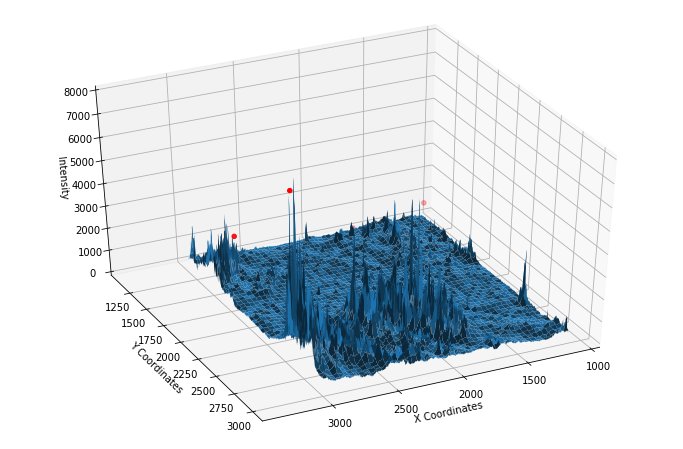

In [23]:
#Se define en una variable el path del directorio
fitsDir = 'DatosJupyterSun/JSOC_AIA_FITS'
#Se llama a la función guardar3DPlotROI, para generar las gráficas
guardar3DPlotROI(fitsDir, picosCircu, sunCenter, rSun, 0.6)

Con los picos de alta intensidad identificados en los maps, se procede a realizar el registro de las intensidades a través del tiempo. Se define la función obtenerIntensidadesDePicosROI() que recorrerá los archivos FITS y extraerá las intensidades de los picos dentro del ROI. Se retorna una matriz con la información.

In [30]:
def obtenerIntensidadesDePicosROI (FITS_dirPath, picosEnROI):
    #Se obtiene el path de los archivos FITS contenidos en el directorio
    fitsPaths= sorted(glob(str(FITS_dirPath)+'/*193.image_lev1.fits'))
    matrix = [['Time']]
    
    #Se ingresa la coordenada de los picos de alta intensidad en las columnas de la
    #fila cero.
    for k in range(0, len(picosEnROI)):
        matrix[0].append(picosEnROI[k])
    
    #Se itera sobre los archivos FITS y se extrae la intensidad
    for i in range(0, len(fitsPaths)):
        aiamapFITS_i = sunpy.map.Map(fitsPaths[i])
        row_i = []
        time_obs = str(aiamapFITS_i.meta['date-obs'])
        if('.84' in time_obs):
            row_i.append(parse_time(time_obs))            
            peaks_pos = aiamapFITS_i.data[picosEnROI[:, 0], picosEnROI[:, 1]]
            for s in range(0, len(peaks_pos)):
                row_i.append(peaks_pos[s])
            
            matrix.append(row_i)
        
        
    return np.array(matrix)

Se obtienen las intensidades de los picos de los maps y se imprime.


In [ ]:
matriz = obtenerIntensidadesDePicosROI(fitsDir, picosCircu)
pd.DataFrame(matriz).to_csv('DatosJupyterSun/maxPicosEvolucion.csv', sep='\t', index=False)
print (pd.DataFrame(matriz, index=None, columns=None))

Se crea un TimeSeries con la matriz anterior y se gráfica para ver la evolución de los picos en el tiempo.

In [ ]:
tsROI = sunpy.timeseries.TimeSeries(pd.DataFrame(matriz[1:][1:], index=None, columns=None))
tsROI.peek()

La fucnión arrayMaps() se encarga de mostrar la imágenes en un array para observalas de manera secuencial

In [ ]:
def arrayMaps(FITS_dirPath):
    fitsPaths= sorted(glob(str(FITS_dirPath)+'/*193.image_lev1.fits'))
    img = []
    
    fig = plt.figure(figsize=(40,40))
    for i in range(0, len(fitsPaths)):
        aiamapFITS_i = sunpy.map.Map(fitsPaths[i])
        time_obs = str(aiamapFITS_i.meta['date-obs'])
        if('.84' in time_obs):
            fig.add_subplot(4, 8, i+1)
            aiamapFITS_i.plot()

        
    plt.show()

Se llama a la función arrayMaps para graficar los archivos FITS

In [ ]:
#Se envían los archivos FITS para que se grafiquen en un arreglo
arrayMaps(fitsDir)

La función convert_frames_to_video() se encarga de tomar los frames de las imágenes en 3D del ROI y genera un vídeo para observar mejor la dinámica de los pixeles en la región de interes.


In [ ]:
def convert_frames_to_video(pathIn,pathOut,fps):    
    frame_array = []
    files = sorted(glob(str(pathIn)+'/*.png'))
 
    #for sorting the file names properly
    
    for i in range(len(files)):
        filename=files[i]
        #reading each files
        img = cv.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        #inserting the frames into an image array
        frame_array.append(img)
 
    out = cv.VideoWriter(pathOut,cv.VideoWriter_fourcc(*'DIVX'), fps, size)
 
    for i in range(len(frame_array)):
        # writing to a image array
        out.write(frame_array[i])
    out.release()

In [ ]:
#Se define el path del directorio donde están contenidas las imágenes 3D
pathIn = 'DatosJupyterSun/3D'
#Se define el path donde se guardará el video
pathOut = 'DatosJupyterSun/video.avi'
#Es posible ajustar los fotogramas por segundo(fps) del vídeo
fps = 3.0
#Se genera el vídeo con las variables definidas anteriormente
convert_frames_to_video(pathIn, pathOut, fps)